Classes found: ['Diseased', 'Dried', 'Healthy']

Sample entries:
                                                path     class  height  width
0  /kaggle/input/batel-leaf-dataset/Betel Leaf Da...  Diseased    6112   6112
1  /kaggle/input/batel-leaf-dataset/Betel Leaf Da...  Diseased    6112   6112
2  /kaggle/input/batel-leaf-dataset/Betel Leaf Da...  Diseased    6112   6112
3  /kaggle/input/batel-leaf-dataset/Betel Leaf Da...  Diseased    6112   6112
4  /kaggle/input/batel-leaf-dataset/Betel Leaf Da...  Diseased    6112   6112

Class distribution:
class
Dried       340
Healthy     333
Diseased    220
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


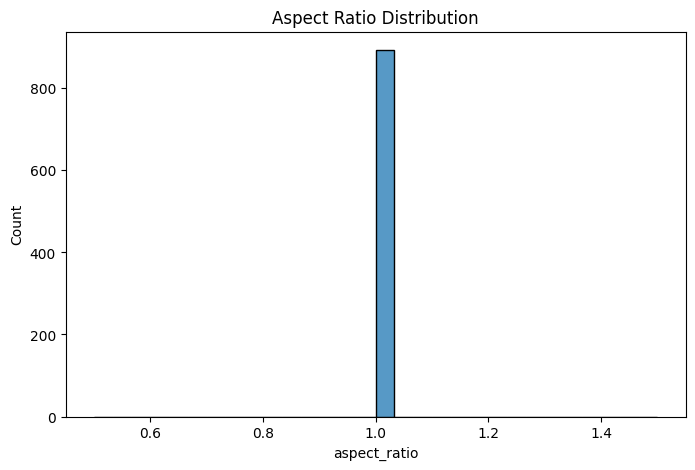

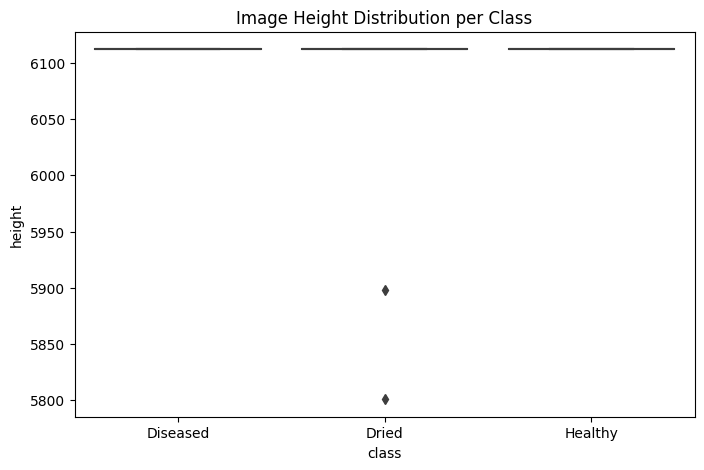

Computing RGB/HSV stats: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]



RGB/HSV mean/std summary:
           R_mean      R_std      G_mean      G_std      B_mean      B_std  \
count   20.000000  20.000000   20.000000  20.000000   20.000000  20.000000   
mean   158.223602  60.500712  166.787008  37.458642  163.011909  41.771130   
std      8.296913   7.185983    7.285863  11.869491    7.006443   8.167971   
min    142.968054  43.435114  145.645051  17.860924  145.667454  24.750282   
25%    153.833568  56.442079  163.837845  29.761833  159.615000  39.147868   
50%    158.466304  60.596207  167.415784  34.063269  162.417403  40.962408   
75%    160.476589  64.240123  172.632145  46.514551  166.925191  46.126167   
max    173.622374  73.600806  176.920709  59.265041  174.220334  56.912105   

           H_mean     S_mean      V_mean  
count   20.000000  20.000000   20.000000  
mean    93.792637  35.354346  170.203615  
std      6.839521   9.252077    6.698205  
min     74.255337  17.503272  150.926033  
25%     91.032063  30.047899  165.949832  
50%     95.4

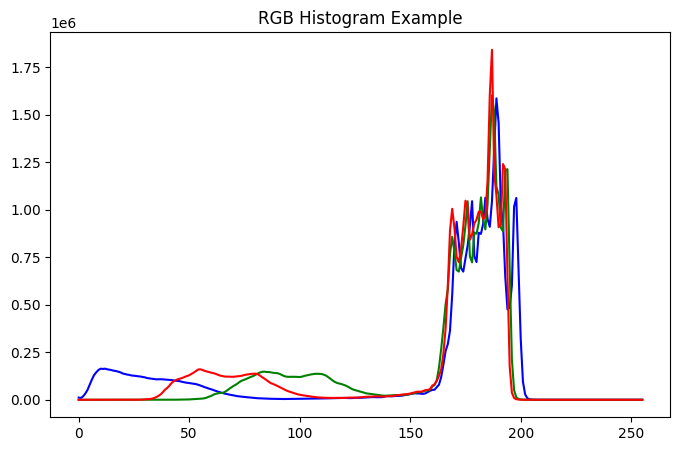

Brightness/Contrast: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]



Brightness mean/std (subset): [164.65112204  41.22281756]


Sharpness: 100%|██████████| 893/893 [11:53<00:00,  1.25it/s]


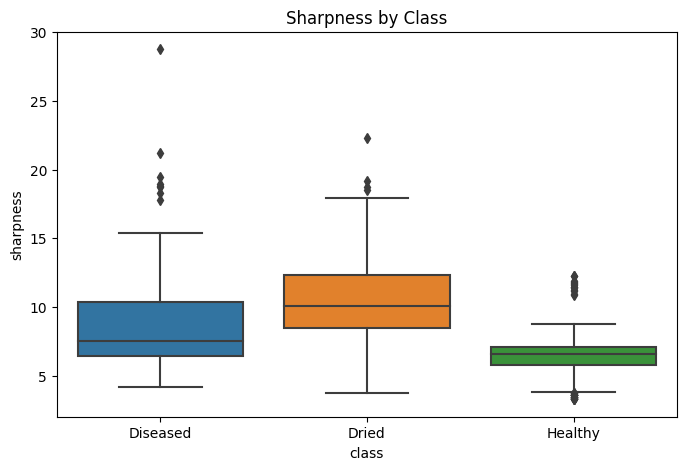

Gray-World Check: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]



Channel means (BGR): [158.22360172 166.78700776 163.01190929]


Checking duplicates: 100%|██████████| 893/893 [07:56<00:00,  1.87it/s]


Found 3 potential duplicates.
Duplicate pair: ('/kaggle/input/batel-leaf-dataset/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_040.jpg', '/kaggle/input/batel-leaf-dataset/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_058.jpg')
Duplicate pair: ('/kaggle/input/batel-leaf-dataset/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_294.jpg', '/kaggle/input/batel-leaf-dataset/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_293.jpg')
Duplicate pair: ('/kaggle/input/batel-leaf-dataset/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment/Healthy/CE_Healthy_Leaf

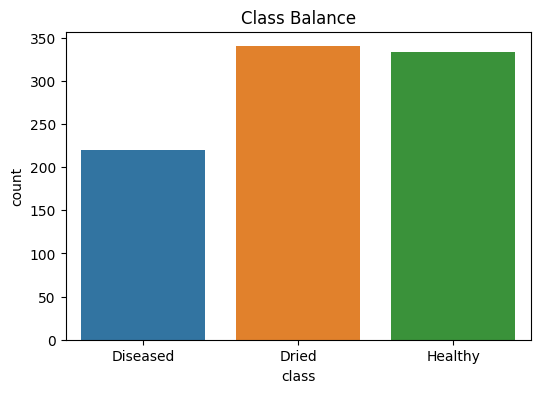


Train: 714 | Test: 179


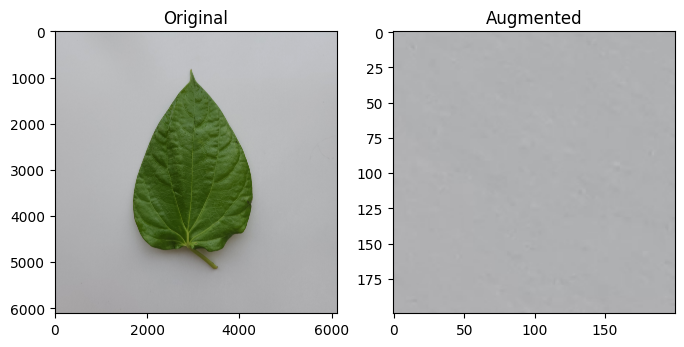

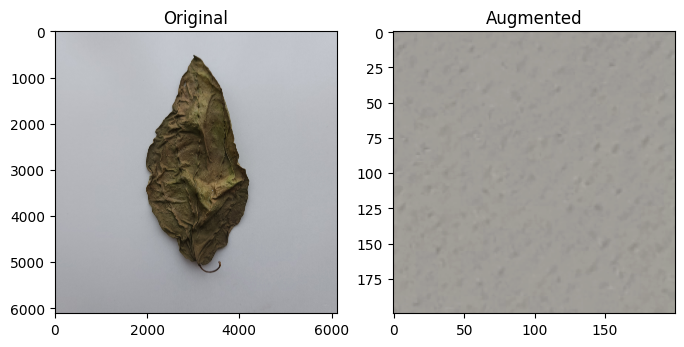

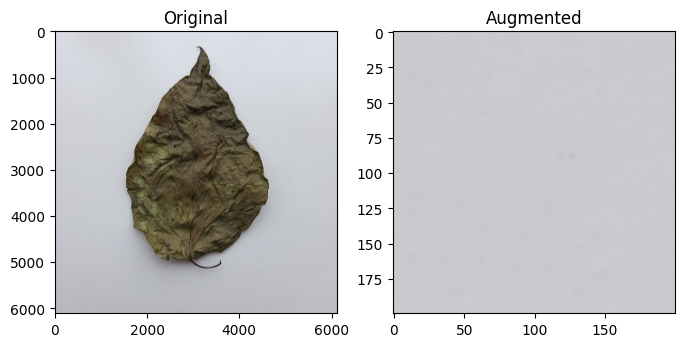


✅ EDA complete — all key outputs displayed.


In [1]:
import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from PIL import Image
import imagehash
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---- CONFIG ----
base_path = "/kaggle/input/batel-leaf-dataset/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset/Controlled Environment"  # change if different
classes = os.listdir(base_path)
print("Classes found:", classes)

# ===============================
# 1. Load basic dataset info
# ===============================
data = []
for cls in classes:
    folder = os.path.join(base_path, cls)
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            data.append([path, cls, h, w])

df = pd.DataFrame(data, columns=["path", "class", "height", "width"])
print("\nSample entries:")
print(df.head())
print("\nClass distribution:")
print(df["class"].value_counts())

# ===============================
# 2. Resolution and Aspect Ratio
# ===============================
df["aspect_ratio"] = df["width"] / df["height"]
plt.figure(figsize=(8,5))
sns.histplot(df["aspect_ratio"], bins=30)
plt.title("Aspect Ratio Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="height", data=df)
plt.title("Image Height Distribution per Class")
plt.show()

# ===============================
# 3. RGB & HSV Statistics
# ===============================
def color_stats(img):
    stats = {}
    for i, ch in enumerate(["R","G","B"]):
        stats[ch+"_mean"] = np.mean(img[:,:,i])
        stats[ch+"_std"] = np.std(img[:,:,i])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    stats["H_mean"] = np.mean(hsv[:,:,0])
    stats["S_mean"] = np.mean(hsv[:,:,1])
    stats["V_mean"] = np.mean(hsv[:,:,2])
    return stats

subset = df.sample(20, random_state=42)
rgb_stats = []
for p in tqdm(subset["path"], desc="Computing RGB/HSV stats"):
    img = cv2.imread(p)
    rgb_stats.append(color_stats(img))
rgb_df = pd.DataFrame(rgb_stats)
print("\nRGB/HSV mean/std summary:")
print(rgb_df.describe())

# Plot RGB hist for one random sample
sample_img = cv2.imread(subset.iloc[0]["path"])
colors = ('b','g','r')
plt.figure(figsize=(8,5))
for i,col in enumerate(colors):
    histr = cv2.calcHist([sample_img],[i],None,[256],[0,256])
    plt.plot(histr, color=col)
plt.title("RGB Histogram Example")
plt.show()

# ===============================
# 4. Brightness/Contrast Spread
# ===============================
def brightness_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.mean(), gray.std()

br_ct = []
for p in tqdm(subset["path"], desc="Brightness/Contrast"):
    img = cv2.imread(p)
    br_ct.append(brightness_contrast(img))
br_ct = np.array(br_ct)
print("\nBrightness mean/std (subset):", br_ct.mean(axis=0))

# ===============================
# 5. Sharpness/Noise Proxy (Laplacian)
# ===============================
def sharpness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

df["sharpness"] = [sharpness(cv2.imread(p)) for p in tqdm(df["path"], desc="Sharpness")]
plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="sharpness", data=df)
plt.title("Sharpness by Class")
plt.show()

# ===============================
# 6. White Balance (Gray-World)
# ===============================
means = []
for p in tqdm(subset["path"], desc="Gray-World Check"):
    img = cv2.imread(p)
    means.append(np.mean(img, axis=(0,1)))
means = np.array(means)
print("\nChannel means (BGR):", means.mean(axis=0))

# ===============================
# 7. Duplicate Detection (Perceptual Hash)
# ===============================
hashes = {}
dupes = []
for p in tqdm(df["path"], desc="Checking duplicates"):
    try:
        h = imagehash.phash(Image.open(p))
        if h in hashes:
            dupes.append((p, hashes[h]))
        else:
            hashes[h] = p
    except:
        pass

print(f"\nFound {len(dupes)} potential duplicates.")
if dupes:
    for d in dupes[:5]:
        print("Duplicate pair:", d)

# ===============================
# 8. Class Balance Plot
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Class Balance")
plt.show()

# ===============================
# 9. Train-Test Split (Leakage Safeguard)
# ===============================
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)
print(f"\nTrain: {len(train_df)} | Test: {len(test_df)}")

# ===============================
# 10. Augmentation Probe
# ===============================
transform = A.Compose([
    A.RandomCrop(height=200, width=200),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(p=0.3),
    ToTensorV2()
])

sample_paths = list(subset["path"].values)[:3]
for p in sample_paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    augmented = transform(image=img)["image"].permute(1,2,0).numpy()
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(augmented); plt.title("Augmented")
    plt.show()

print("\n✅ EDA complete — all key outputs displayed.")
